In [1]:
!pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.6 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=186c4011345cfa6327b04012791f1b540407af71bf282bfdc609bc2b5f454102
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24570 sha256=acae6dffb75cb88910dda9e33915cc4cacd71889ef88972cf78fc63a34c98c9b
  Stored in directory: /root/.cache/pip/wheels/70/4b/f0/ea

## Import libraries

In [90]:
# Import libraries 
import numpy as np
import pandas as pd
import time as tm
import datetime as dt
import tensorflow as tf

from yahoo_fin import stock_info as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Activation
from keras.layers import Bidirectional

# Graphics library
import matplotlib.pyplot as plt

## Declare variables and create initial DataFrame from Yahoo Financial data

In [142]:
# Declare variables
# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, Goldman Sachs
STOCK = 'GS'

# Current date
date_now = tm.strftime('2023-06-01')
date_4_years_back = tm.strftime('2016-01-01')

# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_4_years_back, 
    end_date=date_now, 
    interval='1d')

# display data
init_df

,open,high,low,close,adjclose,volume,ticker
2016-01-04,175.789993,177.190002,173.759995,177.139999,153.384598,3745500,GS
2016-01-05,176.710007,177.500000,172.919998,174.089996,150.743637,4521600,GS
2016-01-06,171.309998,172.020004,169.100006,169.839996,147.063538,5539400,GS
2016-01-07,166.669998,169.500000,163.600006,164.619995,142.543579,5687900,GS
2016-01-08,166.750000,168.419998,163.630005,163.940002,141.954758,4929800,GS
...,...,...,...,...,...,...,...
2023-05-24,320.390015,321.899994,318.799988,319.809998,317.393280,1439100,GS
2023-05-25,318.920013,325.179993,318.799988,323.880005,321.432526,1618500,GS
2023-05-26,324.720001,332.869995,324.000000,332.010010,329.501099,2718700,GS
2023-05-30,332.079987,332.529999,327.730011,330.829987,328.329987,1998600,GS


In [143]:
# Below creates a new dataframe for possible training dataset

# Current date
date_now = tm.strftime('2023-01-01')
date_3_years_back = tm.strftime('2016-01-01')

# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
train_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

# display data
train_df

,open,high,low,close,adjclose,volume,ticker
2016-01-04,175.789993,177.190002,173.759995,177.139999,153.384567,3745500,GS
2016-01-05,176.710007,177.500000,172.919998,174.089996,150.743591,4521600,GS
2016-01-06,171.309998,172.020004,169.100006,169.839996,147.063522,5539400,GS
2016-01-07,166.669998,169.500000,163.600006,164.619995,142.543594,5687900,GS
2016-01-08,166.750000,168.419998,163.630005,163.940002,141.954758,4929800,GS
...,...,...,...,...,...,...,...
2022-12-23,344.839996,347.760010,343.109985,345.510010,340.461273,1062000,GS
2022-12-27,346.510010,347.750000,341.790009,341.970001,336.973022,1035000,GS
2022-12-28,340.500000,342.850006,339.299988,340.869995,335.889069,1117200,GS
2022-12-29,342.440002,344.640015,341.239990,343.429993,338.411682,1273600,GS


In [144]:
# Below creates possible testing dataset

# Current date
start = tm.strftime('2023-01-01')
end = tm.strftime('2023-06-01')

# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
test_df = yf.get_data(
    STOCK, 
    start_date=start, 
    end_date=end, 
    interval='1d')

# display data
test_df

,open,high,low,close,adjclose,volume,ticker
2023-01-03,345.500000,348.600006,342.809998,346.220001,341.160889,1589700,GS
2023-01-04,348.029999,350.309998,345.079987,347.700012,342.619293,1881000,GS
2023-01-05,344.250000,345.140015,340.140015,343.760010,338.736847,1397800,GS
2023-01-06,347.299988,349.000000,340.950012,348.079987,342.993713,3097800,GS
2023-01-09,351.880005,356.500000,349.500000,353.000000,347.841827,1989000,GS
...,...,...,...,...,...,...,...
2023-05-24,320.390015,321.899994,318.799988,319.809998,317.393280,1439100,GS
2023-05-25,318.920013,325.179993,318.799988,323.880005,321.432526,1618500,GS
2023-05-26,324.720001,332.869995,324.000000,332.010010,329.501099,2718700,GS
2023-05-30,332.079987,332.529999,327.730011,330.829987,328.329987,1998600,GS


## Create new DataFrame from init_df to calculate and add Bollinger Bands to dataset

* Using init_df instead of test_df

In [145]:
# To be used to create Bollinger Bands
init_bband_df = init_df.copy()

# Display the new DataFrame
init_bband_df

,open,high,low,close,adjclose,volume,ticker
2016-01-04,175.789993,177.190002,173.759995,177.139999,153.384598,3745500,GS
2016-01-05,176.710007,177.500000,172.919998,174.089996,150.743637,4521600,GS
2016-01-06,171.309998,172.020004,169.100006,169.839996,147.063538,5539400,GS
2016-01-07,166.669998,169.500000,163.600006,164.619995,142.543579,5687900,GS
2016-01-08,166.750000,168.419998,163.630005,163.940002,141.954758,4929800,GS
...,...,...,...,...,...,...,...
2023-05-24,320.390015,321.899994,318.799988,319.809998,317.393280,1439100,GS
2023-05-25,318.920013,325.179993,318.799988,323.880005,321.432526,1618500,GS
2023-05-26,324.720001,332.869995,324.000000,332.010010,329.501099,2718700,GS
2023-05-30,332.079987,332.529999,327.730011,330.829987,328.329987,1998600,GS


Calculate the Bollinger Band data

In [146]:
# Calculate the Bollinger Band Middle Bank using period of 20 days
period = 20
init_bband_df['mid_band'] = init_bband_df['close'].rolling(window=period).mean()

# Calculate the Bollinger Band Standard Deviation using period of 20 days
init_bband_df['stdev'] = init_bband_df['close'].rolling(window=period).std()

# Calculate the Bollinger Band Upper and Lower Bands using the Middle Bank, Standard Deviation and period of 20 days
init_bband_df['upper_band'] = init_bband_df['mid_band'] + (2 * init_bband_df['stdev'])
init_bband_df['lower_band'] = init_bband_df['mid_band'] - (2 * init_bband_df['stdev'])

# Display DataFrame with the new data
init_bband_df

,open,high,low,close,adjclose,volume,ticker,mid_band,stdev,upper_band,lower_band
2016-01-04,175.789993,177.190002,173.759995,177.139999,153.384598,3745500,GS,NaN,NaN,NaN,NaN
2016-01-05,176.710007,177.500000,172.919998,174.089996,150.743637,4521600,GS,NaN,NaN,NaN,NaN
2016-01-06,171.309998,172.020004,169.100006,169.839996,147.063538,5539400,GS,NaN,NaN,NaN,NaN
2016-01-07,166.669998,169.500000,163.600006,164.619995,142.543579,5687900,GS,NaN,NaN,NaN,NaN
2016-01-08,166.750000,168.419998,163.630005,163.940002,141.954758,4929800,GS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-24,320.390015,321.899994,318.799988,319.809998,317.393280,1439100,GS,327.352499,7.290746,341.933991,312.771007
2023-05-25,318.920013,325.179993,318.799988,323.880005,321.432526,1618500,GS,326.466499,6.502273,339.471044,313.461954
2023-05-26,324.720001,332.869995,324.000000,332.010010,329.501099,2718700,GS,325.895000,5.328226,336.551452,315.238548
2023-05-30,332.079987,332.529999,327.730011,330.829987,328.329987,1998600,GS,325.407999,4.252954,333.913906,316.902091


In [147]:
# Confirm null values in the DataFrame
null_values = init_bband_df.isnull().sum()
print(null_values)

open           0
high           0
low            0
close          0
adjclose       0
volume         0
ticker         0
mid_band      19
stdev         19
upper_band    19
lower_band    19
dtype: int64


In [148]:
# # Replace null values in the first 20 days by back-filling
# init_bband_df['mid_band'] = init_bband_df['mid_band'].bfill()
# init_bband_df['stdev'] = init_bband_df['stdev'].bfill()
# init_bband_df['upper_band'] = init_bband_df['upper_band'].bfill()
# init_bband_df['lower_band'] = init_bband_df['lower_band'].bfill()

# # Check the null values for the first 20 days were backfilled
# init_bband_df.head(30)

In [149]:
# Drop rows with null values
init_bband_df.dropna(inplace=True)

In [150]:
# Confirm there are no more null values in the DataFrame
null_values = init_bband_df.isnull().sum()
print(null_values)

open          0
high          0
low           0
close         0
adjclose      0
volume        0
ticker        0
mid_band      0
stdev         0
upper_band    0
lower_band    0
dtype: int64


In [151]:
# Check the data types in the DataFrame
init_bband_df.dtypes

open          float64
high          float64
low           float64
close         float64
adjclose      float64
volume          int64
ticker         object
mid_band      float64
stdev         float64
upper_band    float64
lower_band    float64
dtype: object

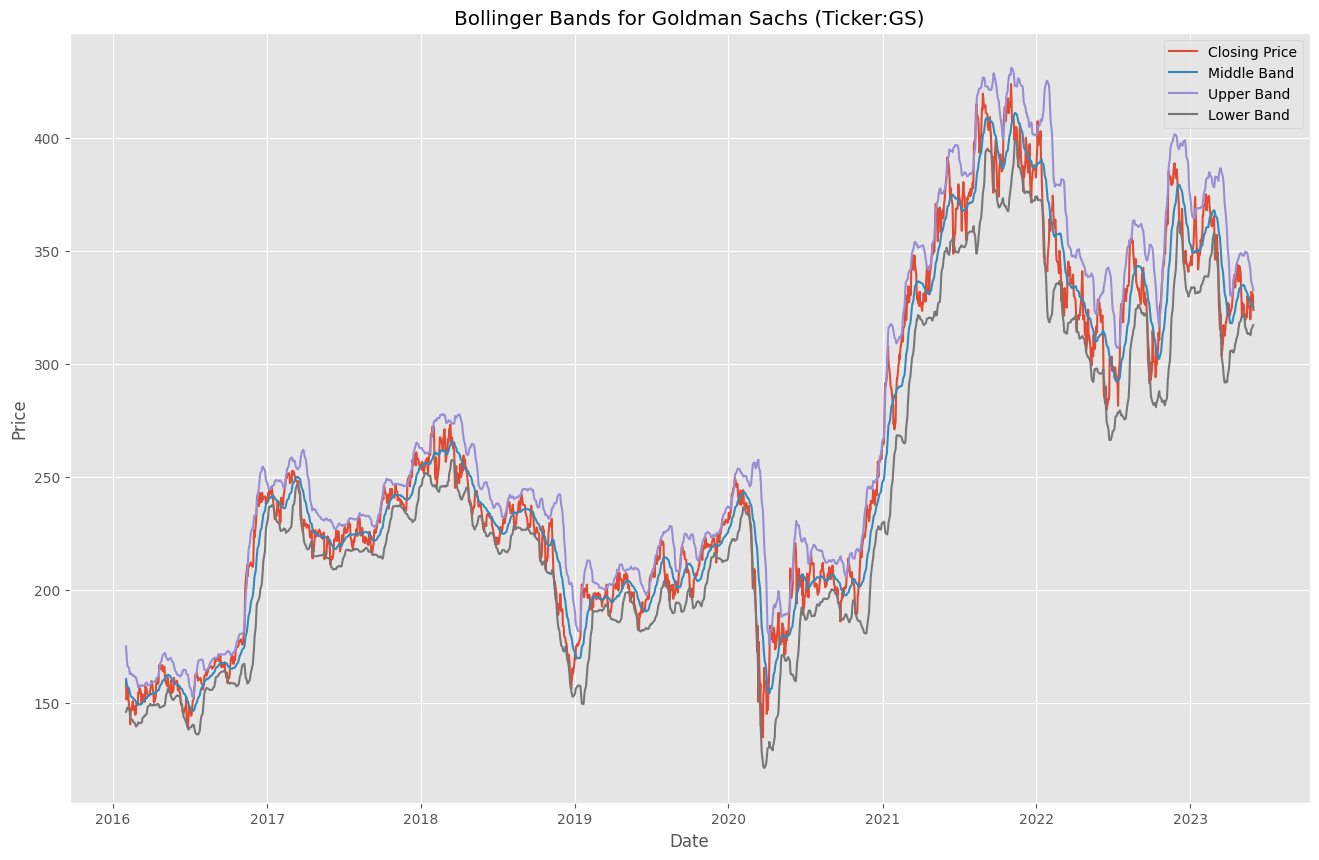

In [152]:
# Plot to check the Bollinger Bands against the Closing Price
plt.figure(figsize=(16, 10))
plt.plot(init_bband_df['close'], label='Closing Price')
plt.plot(init_bband_df['mid_band'], label='Middle Band')
plt.plot(init_bband_df['upper_band'], label='Upper Band')
plt.plot(init_bband_df['lower_band'], label='Lower Band')
plt.legend()
plt.title('Bollinger Bands for Goldman Sachs (Ticker:GS)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [153]:
# Clean up the DataFrame by removing columns the neural network will not use
init_bband_df = init_bband_df.drop(['ticker', 'open', 'high', 'low', 'adjclose', 'stdev'], axis=1)
# Create the column 'date' based on the index column
init_bband_df['date'] = init_bband_df.index

# Display DataFrame
init_bband_df

,close,volume,mid_band,upper_band,lower_band,date
2016-02-01,159.649994,2963500,160.684999,175.146054,146.223944,2016-02-01
2016-02-02,151.699997,6316200,159.412999,172.152772,146.673226,2016-02-02
2016-02-03,152.679993,5893200,158.342499,169.372919,147.312078,2016-02-03
2016-02-04,156.490005,4573100,157.674999,167.302389,148.047610,2016-02-04
2016-02-05,156.470001,4596100,157.267500,166.330547,148.204452,2016-02-05
...,...,...,...,...,...,...
2023-05-24,319.809998,1439100,327.352499,341.933991,312.771007,2023-05-24
2023-05-25,323.880005,1618500,326.466499,339.471044,313.461954,2023-05-25
2023-05-26,332.010010,2718700,325.895000,336.551452,315.238548,2023-05-26
2023-05-30,330.829987,1998600,325.407999,333.913906,316.902091,2023-05-30


## Check outliers

In [154]:
# Check for outliers in order to know which scaler to use for the BBands

# Calculate the quartiles and interquartile range (IQR)
Q1 = init_bband_df['mid_band'].quantile(0.25)
Q3 = init_bband_df['mid_band'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Identify outliers
outliers = init_bband_df[(init_bband_df['mid_band'] < lower_fence) | (init_bband_df['mid_band'] > upper_fence)]

# Print the outliers
print("Outliers:")
print(outliers)


Outliers:
Empty DataFrame
Columns: [close, volume, mid_band, upper_band, lower_band, date]
Index: []


In [155]:
# Check for outliers in order to know which scaler to use for the BBands

# Calculate the quartiles and interquartile range (IQR)
Q1 = init_bband_df['upper_band'].quantile(0.25)
Q3 = init_bband_df['upper_band'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Identify outliers
outliers = init_bband_df[(init_bband_df['upper_band'] < lower_fence) | (init_bband_df['upper_band'] > upper_fence)]

# Print the outliers
print("Outliers:")
print(outliers)


Outliers:
Empty DataFrame
Columns: [close, volume, mid_band, upper_band, lower_band, date]
Index: []


In [156]:
# Check for outliers in order to know which scaler to use for the BBands

# Calculate the quartiles and interquartile range (IQR)
Q1 = init_bband_df['lower_band'].quantile(0.25)
Q3 = init_bband_df['lower_band'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper fences
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Identify outliers
outliers = init_bband_df[(init_bband_df['lower_band'] < lower_fence) | (init_bband_df['lower_band'] > upper_fence)]

# Print the outliers
print("Outliers:")
print(outliers)


Outliers:
Empty DataFrame
Columns: [close, volume, mid_band, upper_band, lower_band, date]
Index: []


## Scale the data

* MinMaxScaler: This scaler is commonly used for scaling stock prices because it preserves the relative relationships between the data points and maps the data to a specific range (e.g., [0, 1]). It can be suitable when you want to retain the original distribution and range of the data.

OR

* RobustScaler: When dealing with stock prices that may have outliers or heavy-tailed distributions, RobustScaler can be more appropriate. It scales the data using robust statistics like the median and interquartile range, making it more robust to outliers.

In [157]:
# Normalize the data using Min-Max scaling
# MinMaxScaler in scikit-learn expects numeric input data and cannot handle datetime values directly. 
# Need to exclude the datetime column from scaling and perform the scaling only on the numeric columns.

# data_to_scale = init_bband_df[['date', 'close', 'mid_band', 'stdev', 'upper_band', 'lower_band']].values
scaler = MinMaxScaler()
scaler_dff = RobustScaler()
scaler_bband = StandardScaler()
init_bband_df['close'] = scaler.fit_transform(np.expand_dims(init_bband_df['close'].values, axis=1))
init_bband_df['volume'] = scaler_dff.fit_transform(np.expand_dims(init_bband_df['volume'].values, axis=1))
init_bband_df['mid_band'] = scaler_bband.fit_transform(np.expand_dims(init_bband_df['mid_band'].values, axis=1))
init_bband_df['lower_band'] = scaler_bband.fit_transform(np.expand_dims(init_bband_df['lower_band'].values, axis=1))
init_bband_df['upper_band'] = scaler_bband.fit_transform(np.expand_dims(init_bband_df['upper_band'].values, axis=1))

# Display the scaled data
init_bband_df

,close,volume,mid_band,upper_band,lower_band,date
2016-02-01,0.085433,0.192397,-1.301979,-1.238811,-1.354463,2016-02-01
2016-02-02,0.057913,2.624710,-1.319643,-1.278007,-1.347913,2016-02-02
2016-02-03,0.061306,2.317832,-1.334509,-1.314408,-1.338600,2016-02-03
2016-02-04,0.074495,1.360128,-1.343778,-1.341521,-1.327877,2016-02-04
2016-02-05,0.074425,1.376814,-1.349437,-1.354247,-1.325591,2016-02-05
...,...,...,...,...,...,...
2023-05-24,0.639850,-0.913523,1.012486,0.945213,1.073508,2023-05-24
2023-05-25,0.653939,-0.783372,1.000183,0.912961,1.083581,2023-05-25
2023-05-26,0.682083,0.014800,0.992246,0.874730,1.109480,2023-05-26
2023-05-30,0.677998,-0.507618,0.985484,0.840193,1.133732,2023-05-30


## Prepare Scaled Data

In [158]:
# Create a function with parameter 'days' 
# When calling this function later in the code, we will pass a value for the days parameter 
# This function will use the init_bband_df.copy after its been cleaned up and scaled


def PrepareData(days):
  # Create a new dataframe based on the scaled dataframe with the Bollinger Band data 
  df = init_bband_df.copy()

  # New column called 'future' is added to the DataFrame
  # The values in the 'future' column are obtained by shifting the 'close' column values upwards by days positions
  # This means that each row in the 'future' column will contain the 'close' price days days in the future
  df['future'] = df['close'].shift(-days)

  # Creates an array 'last_sequence' to take the last days rows from the 'close' and 'stdev' column of the DataFrame df and convert it into a NumPy array
  # The tail(days) function retrieves the last days rows of the DataFrame.
  last_sequence = np.array(df[['close', 'volume', 'mid_band', 'lower_band', 'upper_band']].tail(days))

  # Use dropna() to drop any null values
  df.dropna(inplace=True)

  # Initialize an empty list to store the input sequences and corresponding targets
  sequence_data = []

  # Create a 'deque' object with the maximum length = N_STEPS declared earlier
  # A 'deque' is a double-ended queue that allows efficient appending and removing of elements from both ends
  sequences = deque(maxlen=N_STEPS)

  # Create a loop to go through each row in the DataFrame to create a sequence of 'close' and 'date' from the DataFrame
  # Take the 'close' and 'date' values and combine it into a list called 'entry'
  # Then takes the 'future' value and assigns it to the variable 'target' which is the price in the future we want to predict based on 'close' and 'date'
  for entry, target in zip(df[['close'] + ['volume'] + ['mid_band'] + ['lower_band'] + ['upper_band'] + ['date']].values, df['future'].values):
      # 'entry' is added to the 'sequences' NumPy array
      sequences.append(entry)
      # If the length of 'sequences' equals the values of N_STEPS, we create an input sequence (of 'close' and 'date' values)
      if len(sequences) == N_STEPS:
        # Take the 'input sequence' and corresponding target value and create a pair 
        # Add the pair to the sequence_data list
          sequence_data.append([np.array(sequences), target])
  
  # After the loop is completed, update a variable called 'last_sequence' 
  # Extract the 'close' value from each sequence in the 'sequences' array and appends to o the previous last_sequence array
  # This is to ensure that the final last_sequence contains the 'close' and 'stdev' values from all the sequences processed in the loop, as well as any previous values stored in last_sequence
  # The length of each sequence is restricted to the number of columns in the 'close' array [:len(['close', 'stdev'])] to ensures that only the 'close' and 'stdev' values are extracted, even if there are additional columns in the sequence.
  # The resulting list is concatenated with the previous last_sequence array
  last_sequence = list([s[:len(['close', 'volume', 'mid_band', 'lower_band', 'upper_band'])] for s in sequences]) + list(last_sequence)
  # Convert the above list into a NumPy array and cast to the np.float32 data type
  last_sequence = np.array(last_sequence).astype(np.float32)

  # Construct the X's and Y's
  # Initialize X and Y empty list to store input sequences (X) and targets (Y)
  X, Y = [], []
  # Create a loop to iterate over each pair of input sequence and target data in the 'sequence_data' list
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  # Funciton ends by returning 4 values:
  # df = the modified DataFrame
  # 'last_sequence' array
  # Converted X and Y values
  return df, last_sequence, X, Y

## Train the Model

In [159]:
# Create a new function to train the LSTM model
# Takes two parameters x_train and y_train that represent input features (x_train) and the corresponding target values (y_train) used for training the model
def GetTrainedModel(x_train, y_train):
  # A sequential model will created and it is a model with a linear stack of layers
  model = Sequential()
  # Add the first layer to the LSTM model to take the 3D input data and return the full sequence of outputs by declaring 'return_sequences=True'
  # First layer has 60 memory cells or units 
  # 'input_shape' is defined by value of N_STEPS and the # of 'close' & 'stdev' values and defines the shape of the input data
  # Using bidirectional to allow the model to capture information from both past and future contexts
  model.add(Bidirectional(LSTM(60, return_sequences=True), input_shape=(N_STEPS, len(['close', 'volume', 'mid_band', 'lower_band', 'upper_band']))))
  # Adds a dropout layer of rate=0.3.  
  # Dropout is a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 during training
  model.add(Dropout(0.2))
  # Add another LSTM layer to our model to take the sequence of outputs from the last layer and produce a single output 
  # This layer has 120 memory cells or units 
  model.add(Bidirectional(LSTM(120, return_sequences=False)))
  # Add another dropout layer
  model.add(Dropout(0.2))
  # Add a Dense layer which is a fully connected layer, where each neuron is connected to every neuron in the previous layer
  # This dense layer is a fully connected layer with 20 units
  model.add(Dense(20))
  # Add activation layer
  model.add(Activation('relu'))
  # Adds the final Dense layer with one unit, and is the layer that will produce a single prediction value
  model.add(Dense(1))
  # Add activation layer
  model.add(Activation('relu'))

  # Set the batch size and number of epochs for training
  # 'batch_size' represents the number of samples per gradient update
  # 'epochs' is the number of times the model will iterate over the entire training dataset
  BATCH_SIZE = 8
  EPOCHS = 90

  # Compile the model using the 'mean_squared_error' loss function and the 'adam' optimizer
  # Optimizer is responsible for updating the weights of the neural network during training to minimize the loss function, here we use 'adam'
  # Loss function measures the difference between the predicted output and the actual output, for regression problems like stock price prediction, mean squared error (MSE) is a commonly used loss function
  model.compile(loss='mean_squared_error', optimizer='adam')

  # Train the model using the training data 'x_train' and 'y_train' using the fit() function
  # x_train represents the input features, and y_train represents the target variable (in this case, the closing prices)
  # The epochs parameter specifies the number of times the entire training dataset is passed forward and backward through the neural network
  # The batch_size parameter determines the number of samples used in each training update
  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  # After training the model, a model summary is printed to provide an overview:
  #    The model's architecture 
  #    The no. of trainable parameters
  #    And the output shapes of each layer
  model.summary()

  # At the end of this function, the trained model is returned as an output of the function
  return model

## Prepare Data and Perform Prediction

In [160]:
# Run the function 'PrepareData' by passing 3 as the argument to create input sequences of length 3 days. 
# It will use historical data, such as the 'close' prices from the previous 3 days, to predict the future price
# This helps train the model to learn patterns and relationships in the data based on a 3-day window

PrepareData(3)

(               close    volume  mid_band  upper_band  lower_band       date  \
 2016-02-01  0.085433  0.192397 -1.301979   -1.238811   -1.354463 2016-02-01   
 2016-02-02  0.057913  2.624710 -1.319643   -1.278007   -1.347913 2016-02-02   
 2016-02-03  0.061306  2.317832 -1.334509   -1.314408   -1.338600 2016-02-03   
 2016-02-04  0.074495  1.360128 -1.343778   -1.341521   -1.327877 2016-02-04   
 2016-02-05  0.074425  1.376814 -1.349437   -1.354247   -1.325591 2016-02-05   
 ...              ...       ...       ...         ...         ...        ...   
 2023-05-19  0.661797 -0.836259  1.048384    1.005323    1.081957 2023-05-19   
 2023-05-22  0.657539 -0.870139  1.035163    0.976485    1.086305 2023-05-22   
 2023-05-23  0.652866 -0.832414  1.024117    0.957485    1.084264 2023-05-23   
 2023-05-24  0.639850 -0.913523  1.012486    0.945213    1.073508 2023-05-24   
 2023-05-25  0.653939 -0.783372  1.000183    0.912961    1.083581 2023-05-25   
 
               future  
 2016-02-01  0

In [161]:
# Used the prepared data we ran above and feed into the model to create a prediction
# Declare an empty list to store the predicted prices 
predictions = []

# Create a loop each step in 'LOOKUP_STEPS' which we declared earlier
for step in LOOKUP_STEPS:
  # Within each iteration of the loop, the PrepareData function is called with the current step value
  # Prepares the data for training the model using the specified number of days (step)
  # The returned values from PrepareData are assigned to df, last_sequence, x_train, and y_train
  # The values assigned here will be used later to train the model
  df, last_sequence, x_train, y_train = PrepareData(step)
  # The x_train data is then modified to keep only the 'close' values by slicing it the number of 'close' values
  # This ensures that only the relevant feature ('close') is retained for prediction 
  # The modified x_train is then cast to the np.float32 data type
  x_train = x_train[:, :, :len(['close', 'volume', 'mid_band', 'lower_band', 'upper_band'])].astype(np.float32)

  # Obtain the trained model by calling the GetTrainedModel function with the prepared x_train and y_train data
  # The x_train and y_train variables are obtained from the return values of the PrepareData function within the loop
  # Inside the PrepareData function, the DataFrame df, last_sequence, X, and Y are computed and returned
  # Outside the function, in the loop, the return values are assigned to the variables df, last_sequence, x_train, and y_train
  model = GetTrainedModel(x_train, y_train)

  # The last_sequence of the prepared data is taken and trimmed to the last N_STEPS values
  last_sequence = last_sequence[-N_STEPS:]
  # 'last_sequence' is expanded to have an additional dimension using np.expand_dims to match the input shape required by the model
  last_sequence = np.expand_dims(last_sequence, axis=0)
  # The model's predict method is then called with the modified last_sequence as input to generate a prediction for the future price
  prediction = model.predict(last_sequence)
  # The predicted price is obtained by inverse transforming the prediction using scaler.inverse_transform(prediction)
  # This is to undo any scaling or normalization applied to the data during preparation
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  # Predicted price is rounded to two decimal places using round and then converted to a float, and appended to the predictions list
  predictions.append(round(float(predicted_price), 2))

Epoch 1/90
230/230 [==============================] - 16s 30ms/step - loss: 0.0468
Epoch 2/90
230/230 [==============================] - 6s 24ms/step - loss: 0.0025
Epoch 3/90
230/230 [==============================] - 7s 30ms/step - loss: 0.0022
Epoch 4/90
230/230 [==============================] - 6s 25ms/step - loss: 0.0021
Epoch 5/90
230/230 [==============================] - 7s 30ms/step - loss: 0.0021
Epoch 6/90
230/230 [==============================] - 6s 25ms/step - loss: 0.0018
Epoch 7/90
230/230 [==============================] - 7s 29ms/step - loss: 0.0017
Epoch 8/90
230/230 [==============================] - 6s 25ms/step - loss: 0.0014
Epoch 9/90
230/230 [==============================] - 6s 26ms/step - loss: 0.0014
Epoch 10/90
230/230 [==============================] - 6s 28ms/step - loss: 0.0012
Epoch 11/90
230/230 [==============================] - 6s 25ms/step - loss: 0.0011
Epoch 12/90
230/230 [==============================] - 8s 33ms/step - loss: 0.0014
Epoch 13/90


In [162]:
print(predictions)

[337.97, 328.71, 328.45]


In [163]:
# Save model in case it can be used later 
model.save('GS_bband_trained_model.h5')

## Print the predictions based on the prepared data and trained model

In [164]:
# Summarize the predictions 
# Checks if the predictions list is not empty and contains at least one prediction
if bool(predictions) == True and len(predictions) > 0:
  # If not empty, creates a new list, converts each prediction into a string with $ sign and attaches to the list
  predictions_list = [str(d)+'$' for d in predictions]
  # Joins the elements of the 'prediction_list' into a string separated by a comma and space
  predictions_str = ', '.join(predictions_list)
  # Create a message of the predictions
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  # displays the message
  print(message)

GS prediction for upcoming 3 days (337.97$, 328.71$, 328.45$)


# Execute the trained model on the entire data set

In [165]:
# Execute model for the entire dataset and add the predicted close values to a new DataFrame
# The below code will also transform the predictions back to their original scale and combine them with the original close values
# This allows for further analysis or comparison between the actual and predicted close prices

# First copy the initial DataFrame into the new DataFrame
copy_df = init_bband_df.copy()

# Used the trained model to make predictions on the 'x_train' data and assign it to a new variable
y_predicted = model.predict(x_train)

# Transform the new variable back into the original scale
# Use 'np.squeeze()' function to remove any unnecessary dimensions from the predictions, resulting in a 1D array.
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))

# The first 6 elements of the training data, y_train, are selected and expanded to have an additional dimension using np.expand_dims()
# Then the expanded sequence is then transformed back to its original scale using scaler.inverse_transform()
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))

# The last 3 elements of the training data, y_train, are selected and expanded to have an additional dimension
# Then the expanded sequence is then transformed back to its original scale
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))

# The first_seq array (original-scale predictions for the first six elements) is appended to the y_predicted_transformed array
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)

# The last_seq array (original-scale predictions for the last three elements) is appended to the y_predicted_transformed array.
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)

# A new column named 'predicted_close' is added to the DataFrame 
# The values in this column are populated with the y_predicted_transformed array, which contains the predicted close prices in their original scale.
copy_df[f'predicted_close'] = y_predicted_transformed

# Transform back the closing prices to its original form 
original_close = scaler.inverse_transform(copy_df[['close']])
copy_df['original_close'] = original_close

# Convert the date column to datetime format in dataframes
copy_df['date'] = pd.to_datetime(copy_df['date'])

# Display the new DataFrame
print(copy_df)

58/58 [==============================] - 1s 12ms/step
               close    volume  mid_band  upper_band  lower_band       date  \
2016-02-01  0.085433  0.192397 -1.301979   -1.238811   -1.354463 2016-02-01   
2016-02-02  0.057913  2.624710 -1.319643   -1.278007   -1.347913 2016-02-02   
2016-02-03  0.061306  2.317832 -1.334509   -1.314408   -1.338600 2016-02-03   
2016-02-04  0.074495  1.360128 -1.343778   -1.341521   -1.327877 2016-02-04   
2016-02-05  0.074425  1.376814 -1.349437   -1.354247   -1.325591 2016-02-05   
...              ...       ...       ...         ...         ...        ...   
2023-05-24  0.639850 -0.913523  1.012486    0.945213    1.073508 2023-05-24   
2023-05-25  0.653939 -0.783372  1.000183    0.912961    1.083581 2023-05-25   
2023-05-26  0.682083  0.014800  0.992246    0.874730    1.109480 2023-05-26   
2023-05-30  0.677998 -0.507618  0.985484    0.840193    1.133732 2023-05-30   
2023-05-31  0.654009  0.173897  0.978908    0.822799    1.139291 2023-05-31  

In [166]:
# The below code is adding the predicted results to the copy_df DataFrame for 06/01/2023 and the next two consecutive days (since our data ended 5/31) 
# The below code will generate a code to visualize the Actual and Predicted Closing Prices of the GS stock


# Assigns date_now with June 1, 2023
date_now = dt.date(2023, 6, 1)
# Creates the date for tomorrow and assigns it to the variable date_tomorrow
date_tomorrow = dt.date(2023, 6, 1) + dt.timedelta(days=1)
# Creates the date for the day after tomorrow and assigns it to the variable date_tomorrow
date_after_tomorrow = dt.date(2023, 6, 1) + dt.timedelta(days=2)

# Adds a new row to the DataFrame for date_now containing the predicted price
copy_df.loc[date_now] = [0, 0, 0, 0, 0, f'{date_now}', predictions[0], 0]
# Adds a new row to the DataFrame for date_tomorrow containing the predicted price
copy_df.loc[date_tomorrow] = [0, 0, 0, 0, 0, f'{date_now}', predictions[1], 0]
# Adds a new row to the DataFrame for date_after_tomorrow containing the predicted price
copy_df.loc[date_after_tomorrow] = [0, 0, 0, 0, 0, f'{date_now}', predictions[2], 0]


# Display new DataFrame
copy_df.tail(10)

<ipython-input-166-5160b6674f8e>:17: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_after_tomorrow] = [0, 0, 0, 0, 0, f'{date_now}', predictions[2], 0]


,close,volume,mid_band,upper_band,lower_band,date,predicted_close,original_close
2023-05-22 00:00:00,0.657539,-0.870139,1.035163,0.976485,1.086305,2023-05-22 00:00:00,326.888763,324.920013
2023-05-23 00:00:00,0.652866,-0.832414,1.024117,0.957485,1.084264,2023-05-23 00:00:00,324.641327,323.570007
2023-05-24 00:00:00,0.639850,-0.913523,1.012486,0.945213,1.073508,2023-05-24 00:00:00,320.903748,319.809998
2023-05-25 00:00:00,0.653939,-0.783372,1.000183,0.912961,1.083581,2023-05-25 00:00:00,322.872314,323.880005
2023-05-26 00:00:00,0.682083,0.014800,0.992246,0.874730,1.109480,2023-05-26 00:00:00,332.010010,332.010010
2023-05-30 00:00:00,0.677998,-0.507618,0.985484,0.840193,1.133732,2023-05-30 00:00:00,330.829987,330.829987
2023-05-31 00:00:00,0.654009,0.173897,0.978908,0.822799,1.139291,2023-05-31 00:00:00,323.899994,323.899994
2023-06-01,0.000000,0.000000,0.000000,0.000000,0.000000,2023-06-01,337.970000,0.000000
2023-06-02,0.000000,0.000000,0.000000,0.000000,0.000000,2023-06-01,328.710000,0.000000
2023-06-03,0.000000,0.000000,0.000000,0.000000,0.000000,2023-06-01,328.450000,0.000000


In [167]:
copy_df.dtypes

close              float64
volume             float64
mid_band           float64
upper_band         float64
lower_band         float64
date                object
predicted_close    float64
original_close     float64
dtype: object

## Add back the original closing prices from the saved DataFrame

In [168]:
# To add back the original close price to the DataFrame

# Make a copy of the initial DataFrame
for_merge = init_df.copy()

# Create the column 'date' based on the index column
for_merge['date'] = for_merge.index
for_merge['date'] = pd.to_datetime(for_merge['date'])

# Display
for_merge

,open,high,low,close,adjclose,volume,ticker,date
2016-01-04,175.789993,177.190002,173.759995,177.139999,153.384598,3745500,GS,2016-01-04
2016-01-05,176.710007,177.500000,172.919998,174.089996,150.743637,4521600,GS,2016-01-05
2016-01-06,171.309998,172.020004,169.100006,169.839996,147.063538,5539400,GS,2016-01-06
2016-01-07,166.669998,169.500000,163.600006,164.619995,142.543579,5687900,GS,2016-01-07
2016-01-08,166.750000,168.419998,163.630005,163.940002,141.954758,4929800,GS,2016-01-08
...,...,...,...,...,...,...,...,...
2023-05-24,320.390015,321.899994,318.799988,319.809998,317.393280,1439100,GS,2023-05-24
2023-05-25,318.920013,325.179993,318.799988,323.880005,321.432526,1618500,GS,2023-05-25
2023-05-26,324.720001,332.869995,324.000000,332.010010,329.501099,2718700,GS,2023-05-26
2023-05-30,332.079987,332.529999,327.730011,330.829987,328.329987,1998600,GS,2023-05-30


In [169]:
# Convert the date column to datetime format in dataframes
copy_df['date'] = pd.to_datetime(copy_df['date'])

# Merge the two dataframes based on the date column
merged_df = pd.merge(copy_df, for_merge[['date', 'close']], on='date', how='left')


# Print the merged dataframe
print(merged_df)

       close_x    volume  mid_band  upper_band  lower_band       date  \
0     0.085433  0.192397 -1.301979   -1.238811   -1.354463 2016-02-01   
1     0.057913  2.624710 -1.319643   -1.278007   -1.347913 2016-02-02   
2     0.061306  2.317832 -1.334509   -1.314408   -1.338600 2016-02-03   
3     0.074495  1.360128 -1.343778   -1.341521   -1.327877 2016-02-04   
4     0.074425  1.376814 -1.349437   -1.354247   -1.325591 2016-02-05   
...        ...       ...       ...         ...         ...        ...   
1844  0.677998 -0.507618  0.985484    0.840193    1.133732 2023-05-30   
1845  0.654009  0.173897  0.978908    0.822799    1.139291 2023-05-31   
1846  0.000000  0.000000  0.000000    0.000000    0.000000 2023-06-01   
1847  0.000000  0.000000  0.000000    0.000000    0.000000 2023-06-01   
1848  0.000000  0.000000  0.000000    0.000000    0.000000 2023-06-01   

      predicted_close  original_close     close_y  
0          146.130005      159.649994  159.649994  
1          149.0200

In [170]:
# Convert null values to a specific value
merged_df = merged_df.fillna(0)

# Display DataFrame
merged_df

,close_x,volume,mid_band,upper_band,lower_band,date,predicted_close,original_close,close_y
0,0.085433,0.192397,-1.301979,-1.238811,-1.354463,2016-02-01,146.130005,159.649994,159.649994
1,0.057913,2.624710,-1.319643,-1.278007,-1.347913,2016-02-02,149.020004,151.699997,151.699997
2,0.061306,2.317832,-1.334509,-1.314408,-1.338600,2016-02-03,150.940002,152.679993,152.679993
3,0.074495,1.360128,-1.343778,-1.341521,-1.327877,2016-02-04,147.729996,156.490005,156.490005
4,0.074425,1.376814,-1.349437,-1.354247,-1.325591,2016-02-05,146.910004,156.470001,156.470001
...,...,...,...,...,...,...,...,...,...
1844,0.677998,-0.507618,0.985484,0.840193,1.133732,2023-05-30,330.829987,330.829987,330.829987
1845,0.654009,0.173897,0.978908,0.822799,1.139291,2023-05-31,323.899994,323.899994,323.899994
1846,0.000000,0.000000,0.000000,0.000000,0.000000,2023-06-01,337.970000,0.000000,0.000000
1847,0.000000,0.000000,0.000000,0.000000,0.000000,2023-06-01,328.710000,0.000000,0.000000


## Calculate accuracy for regression-based predictions

Calculate MAE and RMSE

Mean Absolute Error (MAE): MAE measures the average absolute difference between predicted and actual values. It provides a measure of the average prediction error.

Root Mean Squared Error (RMSE): RMSE is the square root of MSE. It provides a more interpretable error metric in the same units as the target variable. Lower RMSE values indicate better accuracy.

In [171]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use the actual prices in a list or array
actual_prices = merged_df['close_y'][:-3]

# Use the predicted prices 
predicted_prices = merged_df['predicted_close'][:-3]

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(actual_prices, predicted_prices)

# Calculate root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

# Print the calculated metrics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 2.7021462718430476
Root Mean Squared Error (RMSE): 3.7663201190949134


<u> Results:</u>

The MAE value of [] means that, on average, the predicted prices differ from the actual prices by approximately $[]

The RMSE value of [] indicates that, on average, the predicted prices deviate from the actual prices by approximately $[] units

Calculate the MAPE

The Mean Absolute Percentage Error (MAPE) is a metric used to evaluate the accuracy of predictions in regression problems. It measures the average percentage difference between the predicted values and the actual values.

In [172]:
def calculate_mape(actual, predicted):
    # Ensure both actual and predicted arrays have the same shape
    actual = actual_prices
    predicted = predicted_prices

    # Calculate the percentage error for each data point
    # Multiplying the below by 100 already converts the number to %
    percentage_errors = np.abs((actual - predicted) / actual) * 100

    # Calculate the mean percentage error
    mape = np.mean(percentage_errors)

    return mape

# Assuming you have the actual prices in a list called actual_prices
# and the predicted prices in a list called predicted_prices
mape = calculate_mape(actual_prices, predicted_prices)

# Round the MAPE value to two decimal places
mape_rounded = round(mape, 2)

print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Percentage Error (MAPE): 1.1884436661107212%


In [173]:
# Print the calculated metrics
message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
print (message)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

GS prediction for upcoming 3 days (337.97$, 328.71$, 328.45$)
Mean Absolute Error (MAE): 2.7021462718430476
Root Mean Squared Error (RMSE): 3.7663201190949134
Mean Absolute Percentage Error (MAPE): 1.1884436661107212%


<u> Results: </u> 

A MAPE of []% indicates that, on average, the predictions have an absolute percentage difference of approximately 0.68% from the actual values. In other words, the model's predictions, on average, deviate by around []% from the true values. The lower the MAPE value, the closer the predictions are to the actual values, indicating a higher level of accuracy.

## Create a chart of the Actual Closing Prices and Predicted Prices

In [174]:
# Set the 'date' column as the index
merged_df.set_index('date', inplace=True)

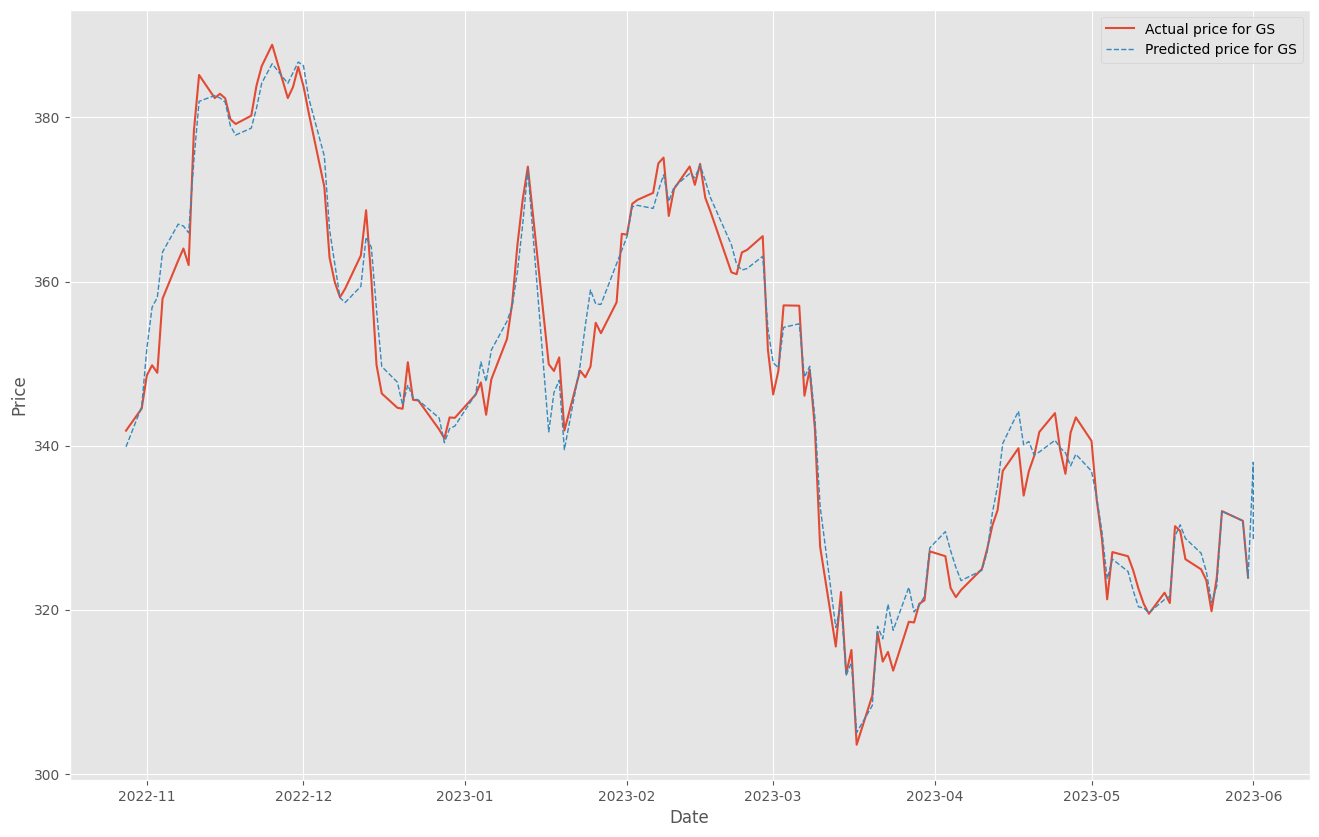

In [175]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
# The closing prices from the DataFrame are plotted for the last 150 rows
# [-150:] selects the last 150 rows, and .head(147) displays the first 147 of those rows
plt.plot(merged_df['close_y'][-150:].head(147))
# This line plots the predicted closing prices from the DataFrame 
# The predicted prices are plotted as a dashed line with a linewidth of 1
plt.plot(merged_df['predicted_close'][-150:].head(150), linewidth=1, linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()